<a href="https://colab.research.google.com/github/hohosznta/AIgeneratedtext/blob/main/Distil_bert%2C_Bert%2C_XLnet%2C_Albert%2C_Roberta%2C_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#!pip install wandb
! pip install -U accelerate
! pip install -U transformers

#!pip install transformers[torch]
#!pip install accelerate = 0.20.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.7 MB/s eta 0:00:00


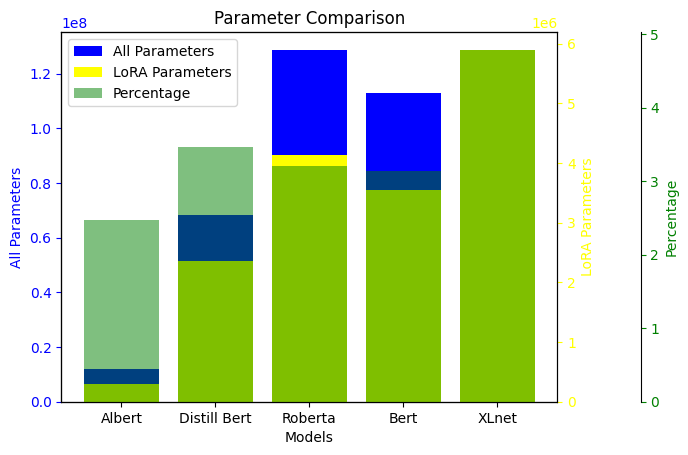

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ["Albert", "Distill Bert", "Roberta", "Bert", "XLnet"]
all_parameters = [11980034, 68143106, 128776706, 113022722, 123207937]
lora_parameters = [295681, 2360833, 4130305, 3539713, 5898240]
percentage = [2.4681148651164095, 3.464522148432741, 3.2073386005074553, 3.1318596273057375, 4.78722405683978]

# Create figure and axes
fig, ax1 = plt.subplots()

# Bar plot for all parameters
ax1.bar(models, all_parameters, color='blue', label='All Parameters')
ax1.set_ylabel('All Parameters', color='blue')
ax1.tick_params('y', colors='blue')

# Create a second y-axis to show LoRA parameters
ax2 = ax1.twinx()
ax2.bar(models, lora_parameters, color='yellow', label='LoRA Parameters')
ax2.set_ylabel('LoRA Parameters', color='yellow')
ax2.tick_params('y', colors='yellow')

# Bar plot for percentage
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.bar(models, percentage, color='green', alpha=0.5, label='Percentage')
ax3.set_ylabel('Percentage', color='green')
ax3.tick_params('y', colors='green')

# Set labels and title
ax1.set_xlabel('Models')
ax1.set_title('Parameter Comparison')

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines + lines2 + lines3, labels + labels2 + labels3, loc='upper left')

plt.show()


In [ ]:
import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.35.2', '0.25.0')

In [ ]:
#!wandb login #2760afae3cddc39355fd83d56a601147e18e1acf

In [ ]:
import pandas as pd
import numpy as np
import transformers
from transformers import (

    BertTokenizerFast,
    BertForSequenceClassification,

    Trainer,
    TrainingArguments
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from transformers import EarlyStoppingCallback
import torch

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [ ]:
def compute_metrics(p):
    pred, labels = p

    # Calculate AUC-ROC
    auc_roc = roc_auc_score(y_true=labels, y_score=pred)

    return {"auc_roc": auc_roc}

#DistilBert

In [ ]:
train_data = pd.read_csv("/content/drive/MyDrive/LLM/train_drcat_04.csv")
test_data = pd.read_csv("/content/drive/MyDrive/LLM/test_essays.csv")
#chat = pd.read_excel('/content/drive/MyDrive/LLM/Chat+Bard.xlsx')
train = pd.read_csv('/content/drive/MyDrive/LLM/train_essays.csv')

In [ ]:
!pip install peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 4.6 MB/s eta 0:00:00


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType

# Define pretrained tokenizer and model
model_name = "bert-base-uncased"
tokenizer =  BertTokenizerFast.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=1)
print(model)
num_params_original = model.num_parameters()
print(num_params_original)

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,target_modules=["query", "key","value"],r=64, lora_alpha=1, lora_dropout=0.01
)
peft_model = get_peft_model(model, peft_config)

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )
print_trainable_parameters(peft_model)
'''
# ----- 1. Preprocess data -----#
# Preprocess data
X = list(train_data["text"])
y = list(train_data["label"])
X_test = list(test_data["text"])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
y_train = [float(label) for label in y_train]
y_val = [float(label) for label in y_val]

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)
test_dataset = Dataset(X_test_tokenized)

# Define Trainer
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
    #report_to="wandb",  # enable logging to W&B
    #run_name="distilbert-base-openai-detector(fixed)",  # name of the W&B run (optional)
    logging_steps=1
)


trainer = Trainer(
    model=peft_model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)


# Train pre-trained model
trainer.train()'''

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

'\n# ----- 1. Preprocess data -----#\n# Preprocess data\nX = list(train_data["text"])\ny = list(train_data["label"])\nX_test = list(test_data["text"])\n\nX_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)\ny_train = [float(label) for label in y_train]\ny_val = [float(label) for label in y_val]\n\nX_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)\nX_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)\nX_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)\n\ntrain_dataset = Dataset(X_train_tokenized, y_train)\nval_dataset = Dataset(X_val_tokenized, y_val)\ntest_dataset = Dataset(X_test_tokenized)\n\n# Define Trainer\nargs = TrainingArguments(\n    output_dir="output",\n    evaluation_strategy="steps",\n    eval_steps=500,\n    per_device_train_batch_size=8,\n    per_device_eval_batch_size=8,\n    num_train_epochs=3,\n    seed=0,\n    load_best_model_at_end=True,\n    #report_

In [ ]:
trainer.model.save_pretrained('albert')
!zip -r /content/model_3.zip /content/albert

tokenizer.save_pretrained("tokenizer_albert")
!zip -r /content/tokenizer.zip /content/tokenizer_albert

  adding: content/albert/ (stored 0%)
  adding: content/albert/README.md (deflated 67%)
  adding: content/albert/adapter_config.json (deflated 47%)
  adding: content/albert/adapter_model.bin (deflated 16%)
updating: content/tokenizer_albert/ (stored 0%)
updating: content/tokenizer_albert/tokenizer.json (deflated 75%)
updating: content/tokenizer_albert/special_tokens_map.json (deflated 49%)
updating: content/tokenizer_albert/tokenizer_config.json (deflated 76%)


In [ ]:
#trainer.model.save_pretrained('xlnet')
!zip -r /content/xlnet.zip /content/xlnet

tokenizer.save_pretrained("tokenizer_xlnet")
!zip -r /content/tokenizer_xlnet.zip /content/tokenizer_xlnet

  adding: content/xlnet/ (stored 0%)
  adding: content/xlnet/adapter_config.json (deflated 48%)
  adding: content/xlnet/adapter_model.bin (deflated 10%)
  adding: content/xlnet/README.md (deflated 66%)
  adding: content/tokenizer_xlnet/ (stored 0%)
  adding: content/tokenizer_xlnet/tokenizer_config.json (deflated 82%)
  adding: content/tokenizer_xlnet/special_tokens_map.json (deflated 52%)
  adding: content/tokenizer_xlnet/tokenizer.json (deflated 75%)


In [ ]:
'''import wandb
wandb.init(project='LLM')

# 실행 이름 설정
wandb.run.name = 'DistilBert3'
wandb.run.save()'''

In [ ]:
tokenizer.save_pretrained('/content/drive/MyDrive/LLM Parameter/Distilbert/token')

('/content/drive/MyDrive/LLM Parameter/Distilbert/token/tokenizer_config.json',
 '/content/drive/MyDrive/LLM Parameter/Distilbert/token/special_tokens_map.json',
 '/content/drive/MyDrive/LLM Parameter/Distilbert/token/vocab.txt',
 '/content/drive/MyDrive/LLM Parameter/Distilbert/token/added_tokens.json',
 '/content/drive/MyDrive/LLM Parameter/Distilbert/token/tokenizer.json')

In [ ]:
!zip -r /content/drive/MyDrive/LLM Parameter/Distilbert/distilbert.zip /content/content/checkpoint-1

	zip warning: name not matched: Parameter/Distilbert/distilbert.zip
updating: content/content/checkpoint-1/ (stored 0%)
updating: content/content/checkpoint-1/config.json (deflated 45%)


In [ ]:
'''#Custom dataset
chat2 = chat[["text", "label"]]

train2 = train[['text', 'generated']].head(18)
train2.rename(columns = {'generated' : 'label'}, inplace=True)

merged_df = pd.concat([chat2, train2], ignore_index=True)

# 결과 확인
merged_df.head()
print(len(merged_df))'''

36


In [ ]:
!zip -r /content/drive/MyDrive/LLM Parameter/Distilbert/token.zip /content/distill_bert_tokenizer

	zip warning: name not matched: Parameter/Distilbert/token.zip
  adding: content/distill_bert_tokenizer/ (stored 0%)
  adding: content/distill_bert_tokenizer/tokenizer.json (deflated 70%)
  adding: content/distill_bert_tokenizer/vocab.txt (deflated 49%)
  adding: content/distill_bert_tokenizer/special_tokens_map.json (deflated 42%)
  adding: content/distill_bert_tokenizer/tokenizer_config.json (deflated 76%)


#모델 예측

In [ ]:
import torch.nn.functional as F

X_test = list(test_data["text"])

#tokenizer = DistilBertTokenizerFast.from_pretrained("/content/drive/MyDrive/LLM Parameter/Distilbert/distilbert/model.safetensors")
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
test_dataset = Dataset(X_test_tokenized)

# Load trained model
#model_path = "/content/drive/MyDrive/LLM Parameter/Distilbert/distilbert/model.safetensors"
#model =DistilBertForSequenceClassification.from_pretrained(model_path, num_labels=1)

# Define test trainer
test_trainer = Trainer(model)

# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)

test_pred = (torch.tensor(raw_pred)).numpy().ravel()
print(test_pred)

[0.01876952 0.01453518 0.01487168]


#Bert

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import BertTokenizerFast, BertForSequenceClassification
from datasets import Dataset
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

# Define pretrained tokenizer and model
model_name = "bert-base-cased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=1)

# ----- 1. Preprocess data -----#
# Preprocess data
X = list(train_data["text"])
y = list(train_data["label"])
X_test = list(test_data["text"])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
y_train = [float(label) for label in y_train]
y_val = [float(label) for label in y_val]

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)
test_dataset = Dataset(X_test_tokenized)

# Define Trainer
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
    report_to="wandb",  # enable logging to W&B
    run_name="bert-base-openai-detector(fixed)",  # name of the W&B run (optional)
    logging_steps=1
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train pre-trained model
trainer.train()

Custom Dataset 예측

In [ ]:
import zipfile
import os

# Replace 'your_path' with the path where you have the zip file
zip_file_path = '/content/drive/MyDrive/LLM Parameter/Bert/fine_tuned_tokenizer.zip'
extract_folder = '/content/'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Replace 'your_path' with the path where you have the zip file
zip_file_path = '/content/drive/MyDrive/LLM Parameter/Bert/fine_tuned_model.zip'
extract_folder = '/content/'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained("/content/content/fine_tuned_Token")
Chat_test = list(merged_df["text"])

# Tokenize the test data
chat_test_tokenized = tokenizer(Chat_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
chat_test_dataset = Dataset(chat_test_tokenized)

# Load the trained model using AutoModelForSequenceClassification
model_path = "/content/content/fine_tuned_model"
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=1, ignore_mismatched_sizes=True)

# Define the test trainer
test_trainer = Trainer(model)

# Make predictions
raw_pred = test_trainer.predict(chat_test_dataset).predictions

# Apply sigmoid activation if necessary
test_pred1 = (torch.tensor(raw_pred)).numpy().ravel()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/content/fine_tuned_model and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([1, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROC AUC test: 1.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


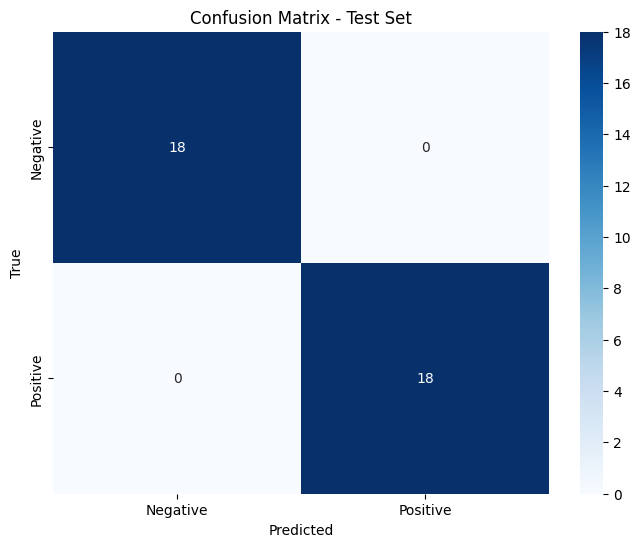

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
preds_test = test_pred1
y_test_vectors = merged_df['label']

# Generate confusion matrix
fpr, tpr, thresholds = roc_curve(y_test_vectors, preds_test)
roc_auc = auc(fpr, tpr)

# You can choose a threshold based on your requirements, for example, maximizing the F1 score
optimal_threshold = thresholds[np.argmax(tpr - fpr)]

# Convert probabilities to binary predictions using the optimal threshold
binary_preds_test = (preds_test >= optimal_threshold).astype(int)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_vectors, binary_preds_test)

# Calculate additional metrics
accuracy = accuracy_score(y_test_vectors, binary_preds_test)
precision = precision_score(y_test_vectors, binary_preds_test)
recall = recall_score(y_test_vectors, binary_preds_test)
f1 = f1_score(y_test_vectors, binary_preds_test)

# Print metrics
print('ROC AUC test:', roc_auc)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()

#XLnet_train

In [ ]:
import wandb
wandb.init(project='LLM')

# 실행 이름 설정
wandb.run.name = 'XLnet'
wandb.run.save()

wandb: Currently logged in as: iuapink0522. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


True

In [ ]:
# Define pretrained tokenizer and model
model_name = "xlnet-base-cased"
tokenizer =  XLNetTokenizerFast.from_pretrained(model_name)
model = XLNetForSequenceClassification.from_pretrained(model_name, num_labels=1)

# ----- 1. Preprocess data -----#
# Preprocess data
X = list(train_data["text"])
y = list(train_data["label"])
X_test = list(test_data["text"])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
y_train = [float(label) for label in y_train]
y_val = [float(label) for label in y_val]

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)
test_dataset = Dataset(X_test_tokenized)

# Define Trainer
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
    report_to="wandb",  # enable logging to W&B
    run_name="xlnet-base-openai-detector(fixed)",  # name of the W&B run (optional)
    logging_steps=1
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

# Train pre-trained model
trainer.train()

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Auc Roc
500,0.013800,0.033293,0.998018
1000,0.025700,0.021331,0.995633
1500,0.002200,0.041292,0.996228
2000,0.128400,0.012623,0.998048
2500,0.002100,0.038326,0.998102
3000,0.112600,0.017101,0.998425
3500,0.210000,0.140601,0.979557


TrainOutput(global_step=3500, training_loss=0.03651865804931315, metrics={'train_runtime': 4268.2766, 'train_samples_per_second': 24.856, 'train_steps_per_second': 3.107, 'total_flos': 7976581681152000.0, 'train_loss': 0.03651865804931315, 'epoch': 0.79})

In [ ]:
model_save_path = "/content/drive/MyDrive/LLM Parameter/xlnet"
trainer.save_model(model_save_path)

config_save_path = '/content/drive/MyDrive/LLM Parameter/xlnet'
model.config.save_pretrained(config_save_path)

custom dataset

In [ ]:
import zipfile
import os

# Replace 'your_path' with the path where you have the zip file
zip_file_path = '/content/drive/MyDrive/LLM Parameter/XLnet.zip'
extract_folder = '/content/'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

In [ ]:
tokenizer = XLNetTokenizerFast.from_pretrained("/content/file_tokenizer_4/content/xlnet_1")
Chat_test = list(merged_df["text"])

# Tokenize the test data
chat_test_tokenized = tokenizer(Chat_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
chat_test_dataset = Dataset(chat_test_tokenized)

# Load the trained model using AutoModelForSequenceClassification
model_path = "/content/file_4/content/output/checkpoint-2500"
model = XLNetForSequenceClassification.from_pretrained(model_path, num_labels=1, ignore_mismatched_sizes=True)

# Define the test trainer
test_trainer = Trainer(model)

# Make predictions
raw_pred = test_trainer.predict(chat_test_dataset).predictions

# Apply sigmoid activation if necessary
test_pred2 = (torch.tensor(raw_pred)).numpy().ravel()

ROC AUC test: 1.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


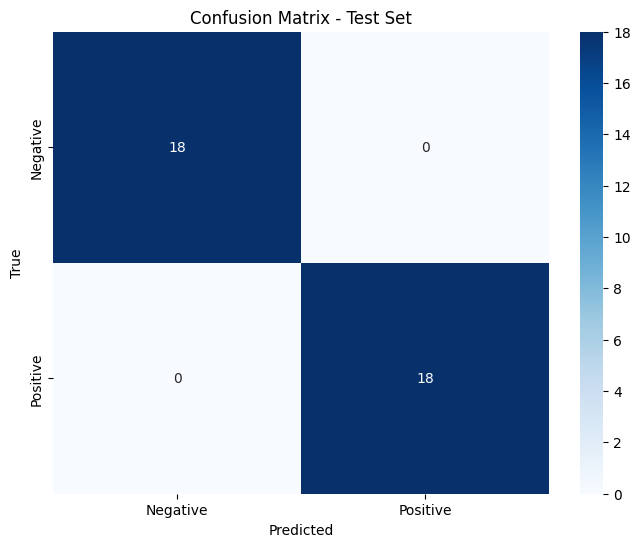

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
preds_test = test_pred2
y_test_vectors = merged_df['label']

# Generate confusion matrix
fpr, tpr, thresholds = roc_curve(y_test_vectors, preds_test)
roc_auc = auc(fpr, tpr)

# You can choose a threshold based on your requirements, for example, maximizing the F1 score
optimal_threshold = thresholds[np.argmax(tpr - fpr)]

# Convert probabilities to binary predictions using the optimal threshold
binary_preds_test = (preds_test >= optimal_threshold).astype(int)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_vectors, binary_preds_test)

# Calculate additional metrics
accuracy = accuracy_score(y_test_vectors, binary_preds_test)
precision = precision_score(y_test_vectors, binary_preds_test)
recall = recall_score(y_test_vectors, binary_preds_test)
f1 = f1_score(y_test_vectors, binary_preds_test)

# Print metrics
print('ROC AUC test:', roc_auc)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()

#Albert_train

In [ ]:
# Define pretrained tokenizer and model
model_name = "aibert-base-cased"
tokenizer =  AlbertTokenizerFast.from_pretrained(model_name)
model = AlbertForSequenceClassification.from_pretrained(model_name, num_labels=1)

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

# ----- 1. Preprocess data -----#
# Preprocess data
X = list(train_data["text"])
y = list(train_data["label"])
X_test = list(test_data["text"])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
y_train = [float(label) for label in y_train]
y_val = [float(label) for label in y_val]

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)
test_dataset = Dataset(X_test_tokenized)


# Define Trainer
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
    report_to="wandb",  # enable logging to W&B
    run_name="aibert-base-cased-openai-detector(fixed)",  # name of the W&B run (optional)
    logging_steps=1
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

# Train pre-trained model
trainer.train()

In [ ]:
model_save_path = "/content/drive/MyDrive/LLM Parameter/AIbert"
trainer.save_model(model_save_path)

config_save_path = '/content/drive/MyDrive/LLM Parameter/AIbert'
model.config.save_pretrained(config_save_path)

custom dataset

In [ ]:
import zipfile
import os

# Replace 'your_path' with the path where you have the zip file
zip_file_path = '/content/drive/MyDrive/LLM Parameter/albert.zip'
extract_folder = '/content/'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

In [ ]:
tokenizer = AlbertTokenizerFast.from_pretrained("/content/file_tokenizer_2/content/albert_1")
Chat_test = list(merged_df["text"])

# Tokenize the test data
chat_test_tokenized = tokenizer(Chat_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
chat_test_dataset = Dataset(chat_test_tokenized)

# Load the trained model using AutoModelForSequenceClassification
model_path = "/content/file_3/content/output/checkpoint-10500"
model = AlbertForSequenceClassification.from_pretrained(model_path, num_labels=1, ignore_mismatched_sizes=True)

# Define the test trainer
test_trainer = Trainer(model)

# Make predictions
raw_pred = test_trainer.predict(chat_test_dataset).predictions

# Apply sigmoid activation if necessary
test_pred3 = (torch.tensor(raw_pred)).numpy().ravel()

ROC AUC test: 1.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


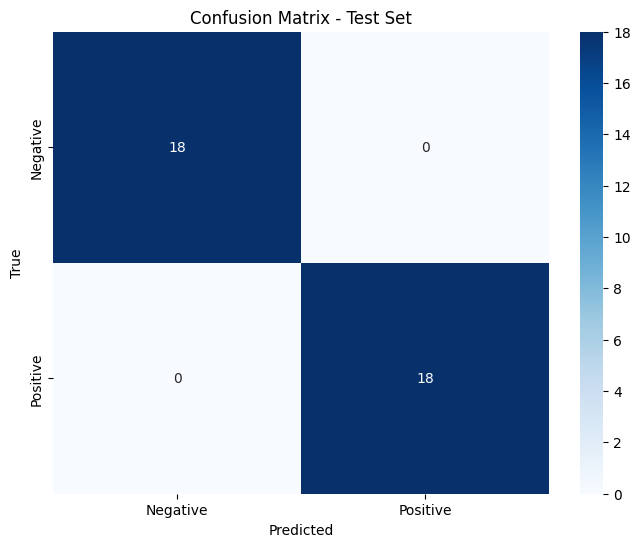

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
preds_test = test_pred3
y_test_vectors = merged_df['label']

# Generate confusion matrix
fpr, tpr, thresholds = roc_curve(y_test_vectors, preds_test)
roc_auc = auc(fpr, tpr)

# You can choose a threshold based on your requirements, for example, maximizing the F1 score
optimal_threshold = thresholds[np.argmax(tpr - fpr)]

# Convert probabilities to binary predictions using the optimal threshold
binary_preds_test = (preds_test >= optimal_threshold).astype(int)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_vectors, binary_preds_test)

# Calculate additional metrics
accuracy = accuracy_score(y_test_vectors, binary_preds_test)
precision = precision_score(y_test_vectors, binary_preds_test)
recall = recall_score(y_test_vectors, binary_preds_test)
f1 = f1_score(y_test_vectors, binary_preds_test)

# Print metrics
print('ROC AUC test:', roc_auc)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()

#Roberta_train

In [ ]:
# Define pretrained tokenizer and model
model_name = "aibert-base-cased"
tokenizer =  AlbertTokenizerFast.from_pretrained(model_name)
model = AlbertForSequenceClassification.from_pretrained(model_name, num_labels=1)

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

# ----- 1. Preprocess data -----#
# Preprocess data
X = list(train_data["text"])
y = list(train_data["label"])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)
test_dataset = Dataset(X_test_tokenized)

# Define Trainer
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
    report_to="wandb",  # enable logging to W&B
    run_name="aibert-base-cased-openai-detector(fixed)",  # name of the W&B run (optional)
    logging_steps=1
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

# Train pre-trained model
trainer.train()

In [ ]:
model_save_path = "/content/drive/MyDrive/LLM Parameter/AIbert"
trainer.save_model(model_save_path)

config_save_path = '/content/drive/MyDrive/LLM Parameter/AIbert'
model.config.save_pretrained(config_save_path)

In [ ]:
import zipfile
import os

# Replace 'your_path' with the path where you have the zip file
zip_file_path = '/content/drive/MyDrive/LLM Parameter/robert.zip'
extract_folder = '/content/'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

In [ ]:
tokenizer = RobertaTokenizerFast.from_pretrained("/content/roberta_1")
Chat_test = list(merged_df["text"])

# Tokenize the test data
chat_test_tokenized = tokenizer(Chat_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
chat_test_dataset = Dataset(chat_test_tokenized)

# Load the trained model using AutoModelForSequenceClassification
model_path = "/content/file_2/content/output/checkpoint-3000"
model = RobertaForSequenceClassification.from_pretrained(model_path, num_labels=1, ignore_mismatched_sizes=True)

# Define the test trainer
test_trainer = Trainer(model)

# Make predictions
raw_pred = test_trainer.predict(chat_test_dataset).predictions

# Apply sigmoid activation if necessary
test_pred4 = (torch.tensor(raw_pred)).numpy().ravel()

ROC AUC test: 0.9753086419753086
Accuracy: 0.9444444444444444
Precision: 1.0
Recall: 0.8888888888888888
F1 Score: 0.9411764705882353


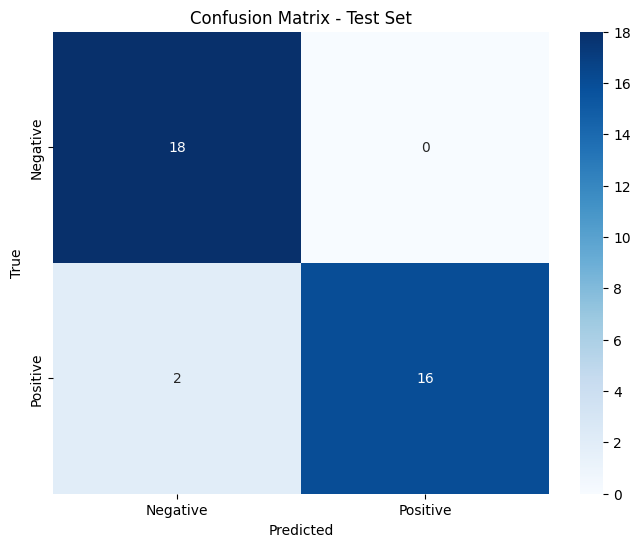

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
preds_tes = test_pred4
y_test_vectors = merged_df['label']

# Generate confusion matrix
fpr, tpr, thresholds = roc_curve(y_test_vectors, preds_test)
roc_auc = auc(fpr, tpr)

# You can choose a threshold based on your requirements, for example, maximizing the F1 score
optimal_threshold = thresholds[np.argmax(tpr - fpr)]

# Convert probabilities to binary predictions using the optimal threshold
binary_preds_test = (preds_test >= optimal_threshold).astype(int)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_vectors, binary_preds_test)

# Calculate additional metrics
accuracy = accuracy_score(y_test_vectors, binary_preds_test)
precision = precision_score(y_test_vectors, binary_preds_test)
recall = recall_score(y_test_vectors, binary_preds_test)
f1 = f1_score(y_test_vectors, binary_preds_test)

# Print metrics
print('ROC AUC test:', roc_auc)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()

#앙상블

In [ ]:
average_pred = (test_pred1 + test_pred2 + test_pred3 + test_pred4) / 4

ROC AUC test: 0.9753086419753086
Accuracy: 0.9444444444444444
Precision: 1.0
Recall: 0.8888888888888888
F1 Score: 0.9411764705882353


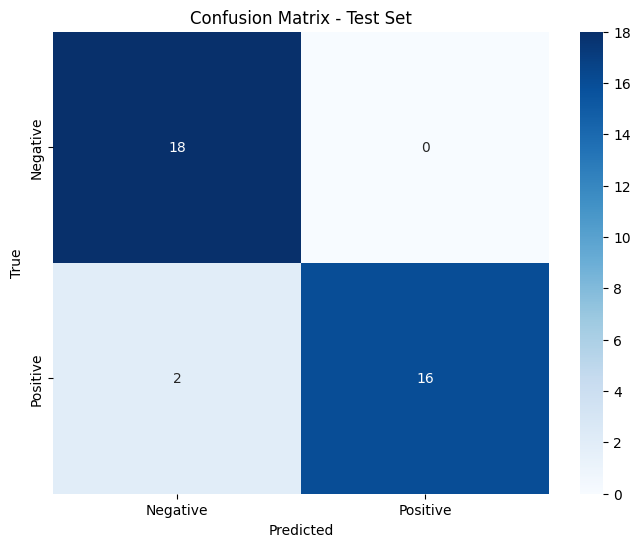

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
preds_tes = average_pred
y_test_vectors = merged_df['label']

# Generate confusion matrix
fpr, tpr, thresholds = roc_curve(y_test_vectors, preds_test)
roc_auc = auc(fpr, tpr)

# You can choose a threshold based on your requirements, for example, maximizing the F1 score
optimal_threshold = thresholds[np.argmax(tpr - fpr)]

# Convert probabilities to binary predictions using the optimal threshold
binary_preds_test = (preds_test >= optimal_threshold).astype(int)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_vectors, binary_preds_test)

# Calculate additional metrics
accuracy = accuracy_score(y_test_vectors, binary_preds_test)
precision = precision_score(y_test_vectors, binary_preds_test)
recall = recall_score(y_test_vectors, binary_preds_test)
f1 = f1_score(y_test_vectors, binary_preds_test)

# Print metrics
print('ROC AUC test:', roc_auc)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()